In [1]:
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from ic_course_utils import find_highest_wf
from ic_course_utils import find_pmap_with_s1_s2
from ic_course_utils import replace_tag

%matplotlib inline

In [2]:
input_file = "data/HEe_fullsim.diomira.h5"
#input_file = "data/HEe_fastsim.diomira.h5"
#input_file = "data/Kr83_fullsim.diomira.h5"
#input_file = "data/Kr83_fastsim.diomira.h5"

# Input file structure

The input file contains three nodes (`/RD/pmtrwf`, `/RD/pmtblr` and `sipmrwf`). Of those, `/RD/pmtrwf` and `/RD/pmtblr` contain the PMT and SiPM Raw Waveforms (RWFs), respectively. `/RD/pmtblr` contains the BiLinear-Restored (BLR) signal, that doesn't include the effect of the derivator in the PMT electronics.
These are homogeneous arrays with shape (number of events, number of sensors, number of time samples).
Here the PMT and SiPMs sampling times are fixed to 25 ns and 1 $\mu$s, respectively. This means that PMT waveforms are  40x bigger than the SiPMs ones.

In [3]:
!ptdump -v $input_file:/RD/pmtrwf
!ptdump -v $input_file:/RD/pmtblr
!ptdump -v $input_file:/RD/sipmrwf

/RD/pmtrwf (EArray(10, 12, 32000)shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 4, 32000)
/RD/pmtblr (EArray(10, 12, 32000)shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 4, 32000)
/RD/sipmrwf (EArray(10, 1792, 800)shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 327, 800)


# Input file data visualization

The module `pytables` treats these nodes equivalently to numpy arrays, so we can access them directly. The time information is not stored in the file as it is implicit, from the sampling period of the detectors (which was set in the city that generated this data (`Buffy` or `Detsim`).

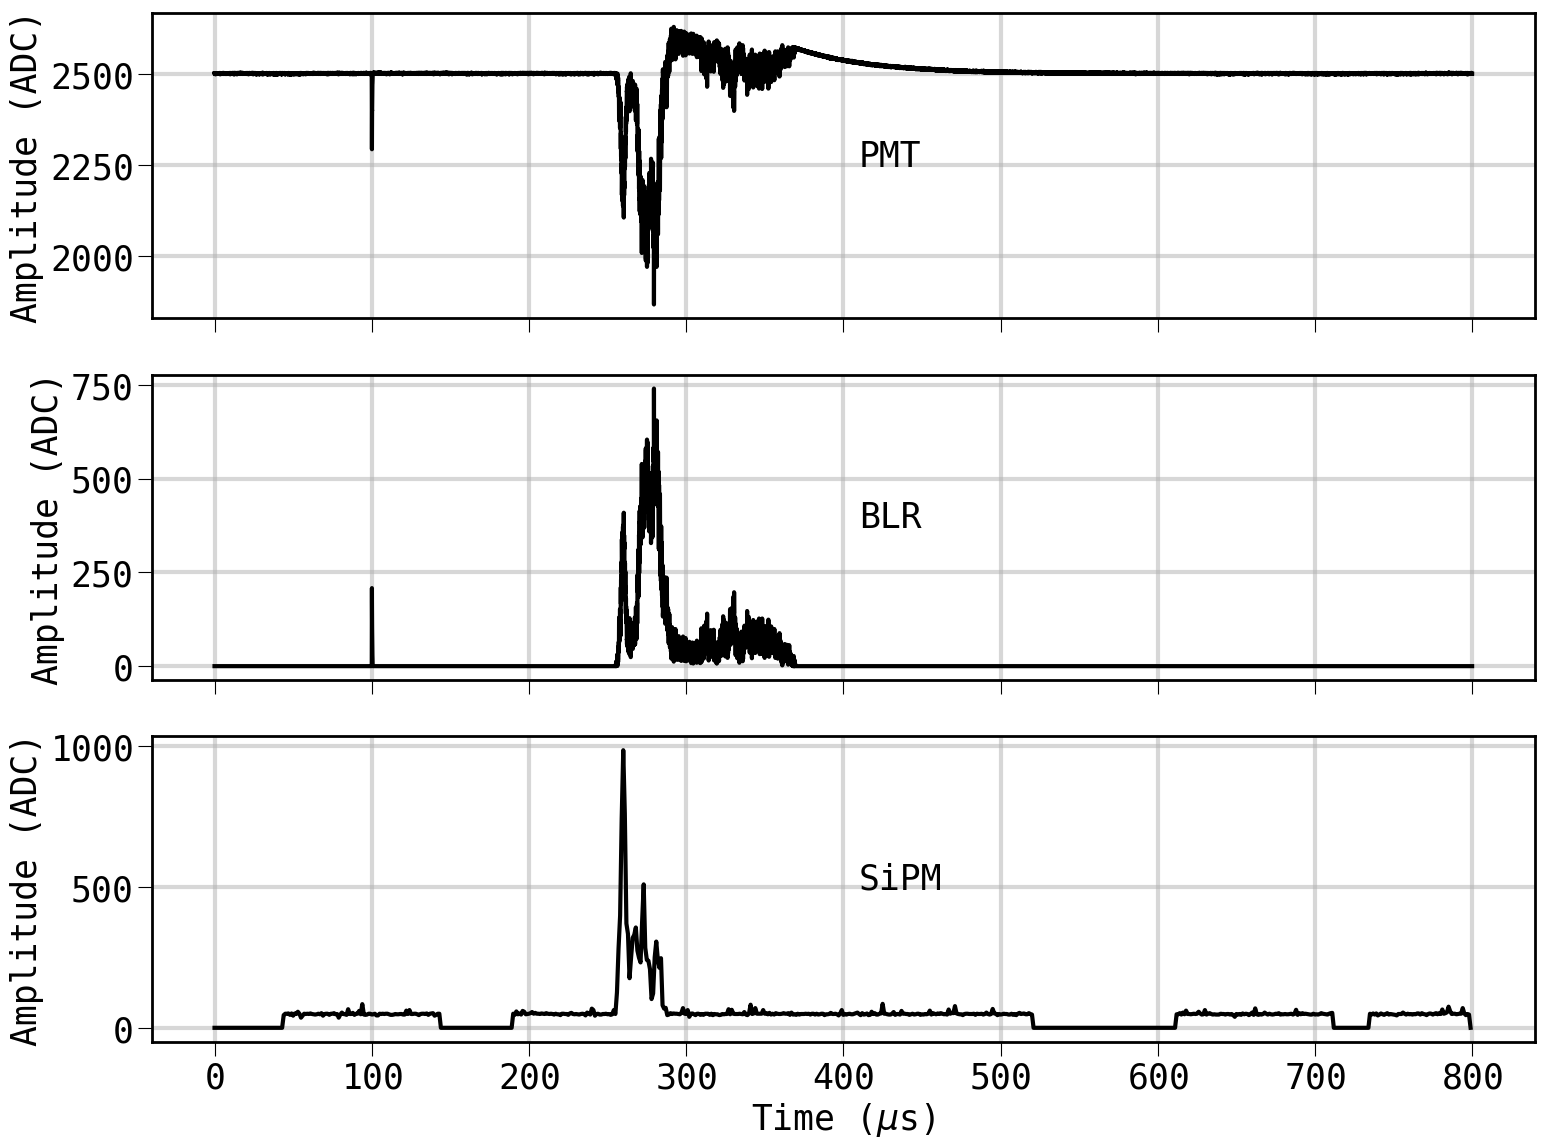

In [4]:
event_number = 1
with tb.open_file(input_file) as file:
    wf_pmt  = find_highest_wf(file.root.RD. pmtrwf, event_number)
    wf_blr  = find_highest_wf(file.root.RD. pmtblr, event_number)
    wf_sipm = find_highest_wf(file.root.RD.sipmrwf, event_number)

    sp_pmt  = 25e-3 # sampling period in mus
    sp_sipm = 1     # sampling period in mus
    t_pmt   = np.arange(wf_pmt .size) * sp_pmt
    t_sipm  = np.arange(wf_sipm.size) * sp_sipm

    _, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
    ax1.plot(t_pmt , wf_pmt ); ax1.text(410, (wf_pmt .max() + wf_pmt.min())/2, "PMT" );                                 ax1.set_ylabel("Amplitude (ADC)")
    ax2.plot(t_pmt , wf_blr ); ax2.text(410, wf_blr .max()                 /2, "BLR" );                                 ax2.set_ylabel("Amplitude (ADC)")
    ax3.plot(t_sipm, wf_sipm); ax3.text(410, wf_sipm.max()                 /2, "SiPM"); ax3.set_xlabel("Time ($\mu$s)");ax3.set_ylabel("Amplitude (ADC)")

Here we observe the main effects of the electronics:
- Baseline: Both PMT and SiPM waveforms have a non-null baseline
  - ~2500 ADC for PMTs
  - ~30 ADC for SiPMs
- Sampling rate: the PMT sampling rate is fixed to 25 ns (the same as the detector electronics)
- Noise: Both PMT and SiPM waveforms contain fluctuations around the baseline
- Bipolar/Unipolar signal: the PMT electronics produced bipolar signals. The BLR waveform shows what the waveform looks like after removing this effect.
- Zero suppression: The SiPM waveforms are zero-suppressed. That is, below a certain threshold, the waveform is set to 0. When the amplitude goes above the threshold, the region before and after the pulse is kept.
- The waveforms are expressed in ADC, not it photoelectrons

The BLR signal is not used further in the processing chain. But it is useful for cross-checks and debugging. 

# Irene

## Description

Finds peaks in the PMTs waveforms and slices all waveforms in those regions.

This city reads Raw Waveforms (RWFs) produced by Diomira or by the real detector and produces Peak Maps (a.k.a PMaps).
This includes a number of data operations:
- Remove the signal-derivative effect of the PMT waveforms
- Calibrate PMTs and SiPMs to translate ADC to photoelectrons (pes)
- Removal of the sensors' baseline
- Resampling of the PMT waveforms to match the SiPM sampling frequency
- Find pulses in the PMT-summed waveform
- Match the time window of the PMT pulse with those in the SiPMs

More details in the official documentation:
https://next-exp-sw.readthedocs.io/en/latest/irene.html

## Parameters

| Parameter | Type  | Description |
|:--------:|:--------:|:--------:|
| `n_baseline` | `int` | Number of PMT waveform samples to use for determine the baseline (guideline: 90% of the total)|
| `n_maw` | `int` | Number of samples to include in the moving average window used for detection of S1 pulses |
| `thr_maw` | `float` | Threshold over the MAW for S1 detection |
| `thr_sipm` | `float` | Per-sample threshold for SiPMs. Samples below this threshold are discarded  (\*) |
| `thr_sipm_type` | `SiPMThreshold` | Method used for SiPM threshold application. Options: common, individual (\*) |
| `s1_lmin`, `s1_lmax`, `s2_lmin`, `s2_lmax` | `int` | Minimum/Maximum length of S1 or S2 signals in number of samples |
| `s1_tmin`, `s1_tmax`,`s2_tmin`, `s2_tmax`  | `float` | Minimum/Maximum buffer time in which to search for S1 or S2 signals |
| `s1_rebin_stride`, `s2_rebin_stride` | `int` | Resampling factor for PMT waveforms. Their value should be such that both sensors are sampled at the same rate |
| `s1_stride`, `s2_stride` | `int` | Maximum number of samples, for which a waveform can dip below the threshold without ending the peak (\*\*) |
| `thr_csum_s1`, `the_csum_s2` | `float` | Threshold applied to the PMT-summed waveform for S1 and S2 peak finding |
| `thr_sipm_s2` | `float` | Per-peak threshold for SiPMs. Those sensors with less counts than this value are not included in the peak |
| `pmt_samp_wid` | `float` | Sampling width of PMTs (\*\*\*) |
| `sipm_samp_wid` | `float` | Sampling width of SiPMs (\*\*\*) |

(\*) The interpretation of `thr_sipm` depends on the value of `thr_sipm_type`. Here we will focus on `thr_sipm_type = common`, which applies the same threshold to all SiPMs and is the option used in the standard data processing. See the official documentation for more details.

(\*\*) If a waveform dips below the threshold momentarily, but goes above it again, these two parts of the waveform and their in-between samples are joined together into a single pulse

(\*\*\*) Must match the data in the input file. This option will probably be removed in the future and the value will be read from the input file

## Configuration

A typical Irene configuration file for NEW data.

Note that here we don't specify the input and output files in the config file, but you can do so!

In [5]:
config_file = "config_files/irene.conf"

In [6]:
!cat $config_file

compression = 'ZLIB4'
event_range = all
print_mod   = 1

run_number = -6400
detector_db = 'new'

n_baseline =   28000 # for a window of 800 mus

n_maw   = 100
thr_maw =   3 * adc

thr_csum_s1 = 0.5 * pes
thr_csum_s2 = 1.0 * pes

thr_sipm      = 3.5 * pes
thr_sipm_type = common

s1_tmin       =  99 * mus # position of S1 in MC files at 100 mus
s1_tmax       = 101 * mus # change tmin and tmax if S1 not at 100 mus
s1_stride     =   4       # minimum number of 25 ns bins in S1 searches
s1_lmin       =   4       # 4 x 25 = 100 ns
s1_lmax       =  20       # 20 x 25 = 500 ns
s1_rebin_stride = 1       # Do not rebin S1 by default

s2_tmin     =    101 * mus # assumes S1 at 100 mus, change if S1 not at 100 mus
s2_tmax     =   1199 * mus # end of the window
s2_stride   =     40       #  40 x 25 = 1   mus
s2_lmin     =    100       # 100 x 25 = 2.5 mus
s2_lmax     = 100000       # maximum value of S2 width
s2_rebin_stride = 40       # Rebin by default, 40 25 ns time bins to make one 1us time bin

## City execution

In [7]:
output_file = replace_tag(input_file, "diomira", "irene")
output_file

'data/HEe_fullsim.irene.h5'

In [8]:
!city irene $config_file -i $input_file -o $output_file

NumExpr defaulting to 4 threads.
Using selector: EpollSelector
events processed: 0, event number: 0
events processed: 1, event number: 13
events processed: 2, event number: 26
events processed: 3, event number: 39
events processed: 4, event number: 52
events processed: 5, event number: 65
events processed: 6, event number: 78
events processed: 7, event number: 91
events processed: 8, event number: 104
events processed: 9, event number: 117


## Output

PMaps: a collection of peaks for each event. Each peak contains the waveform slices of each PMT and SiPM with signal. The data is stored in 5 different nodes:
- `/PMAPS/S1`: holds the PMT-summed waveform slices of S1 signals
- `/PMAPS/S1Pmt`: holds the individual PMT waveform slices of S1 signals
- `/PMAPS/S2`: holds the PMT-summed waveform slices of S2 signals
- `/PMAPS/S2Pmt`: holds the individual PMT waveform slices of S2 signals
- `/PMAPS/S2Si`: holds the individual SiPM waveform slices of S2 signals

These are tables with the following columns.
- For `S1`and `S2`: event, peak number, waveform time, bin width and amplitude (of the PMT-summed waveform)
- For `S1Pmt`and `S2Pmt` and `S2Si`: event, peak number, sensor id and amplitude (of the individual sensor waveform)

In [9]:
!ptdump -v $output_file:/PMAPS

/PMAPS (Group) ''
/PMAPS/S1 (Table(154,)shuffle, zlib(4)) 'S1 Table'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "peak": UInt8Col(shape=(), dflt=0, pos=1),
  "time": Float32Col(shape=(), dflt=0.0, pos=2),
  "bwidth": Float32Col(shape=(), dflt=0.0, pos=3),
  "ene": Float32Col(shape=(), dflt=0.0, pos=4)}
  byteorder := 'little'
  chunkshape := (3120,)
  autoindex := True
  colindexes := {
    "event": Index(6, mediumshuffle, zlib(1)).is_csi=False}
/PMAPS/S1Pmt (Table(1848,)shuffle, zlib(4)) 'S1Pmt Table'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "peak": UInt8Col(shape=(), dflt=0, pos=1),
  "npmt": UInt8Col(shape=(), dflt=0, pos=2),
  "ene": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (4681,)
  autoindex := True
  colindexes := {
    "event": Index(6, mediumshuffle, zlib(1)).is_csi=False}
/PMAPS/S2 (Table(1014,)shuffle, zlib(4)) 'S2 Table'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "

### PMap visualization

PMaps have a friendly human interface in IC.
The `Pmap` class is a collection of S1 and S2 `Peak`s:
```
pmap.s1s = [s1_signal_1, s1_signal_2, ...]
pmap.s2s = [s2_signal_1, s2_signal_2, ...]
```
Each `Peak` aggregates 3 objects:
- times: an array of the times corresponding to each waveform sample
- pmts: a SensorResponse object containing the PMT data
- sipms: a SensorResponse object containing the SiPM data

Each `SensorResponse` contains the following information:
- `ids`: the id numbers of the sensors stored in this object
- `all_waveforms`: the waveform slices corresponding to the `times` stored in `Peak`

`Peak` and `SensorResponse` contain several attributes and methods that implement the most common operations on PMaps.

PMaps can be also read as pandas DataFrames.

In [10]:
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df

pmaps    = load_pmaps      (output_file)
pmaps_df = load_pmaps_as_df(output_file)

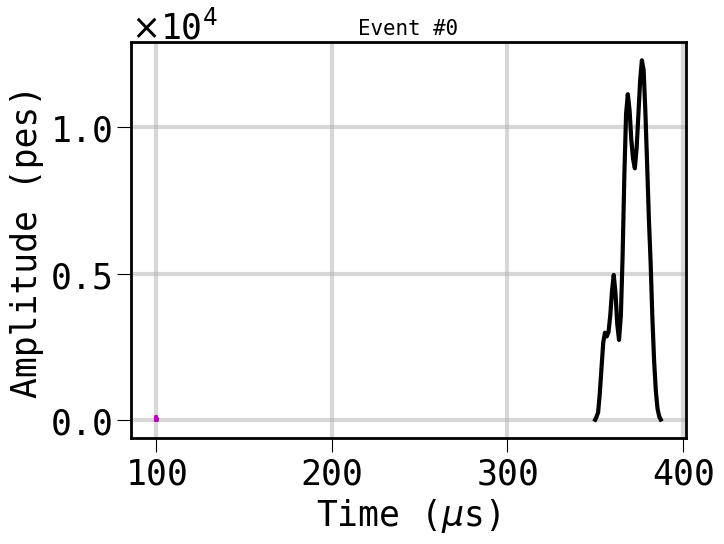

In [11]:
event_number, pmap = find_pmap_with_s1_s2(pmaps)
for s1 in pmap.s1s: # s1 is a `Peak`
    plt.plot(s1.times / 1e3, s1.pmts.sum_over_sensors, "m") # plot the PMT-summed waveform slice

for s2 in pmap.s2s: # s2 is a `Peak`
    plt.plot(s2.times / 1e3, s2.pmts.sum_over_sensors, "k") # plot the PMT-summed waveform slice
    
plt.xlabel("Time ($\mu$s)")
plt.ylabel("Amplitude (pes)")
plt.title(f"Event #{event_number}", fontsize=15);

Some common operations on PMaps (explore the classes in https://github.com/next-exp/IC/blob/master/invisible_cities/evm/pmaps.py for more details):

In [12]:
s1 = pmap.s1s[0]
s2 = pmap.s2s[0]
print(f"The PMT integral of the S2 is {s2.total_energy:.1f} pes")
print(f"The SiPM integral of the S2 is {s2.total_charge:.1f} pes")
print(f"The width of the S2 is {s2.width/1e3:.1f} us")
print(f"The height of the S2 is {s2.height:.1f} pes")
print(f"The S1 of this event happened at {s1.time_at_max_energy/1e3:.2f} us")

The PMT integral of the S2 is 208740.8 pes
The SiPM integral of the S2 is 9913.1 pes
The width of the S2 is 37.6 us
The height of the S2 is 12289.2 pes
The S1 of this event happened at 100.10 us


The same can be achieved with DataFrames:

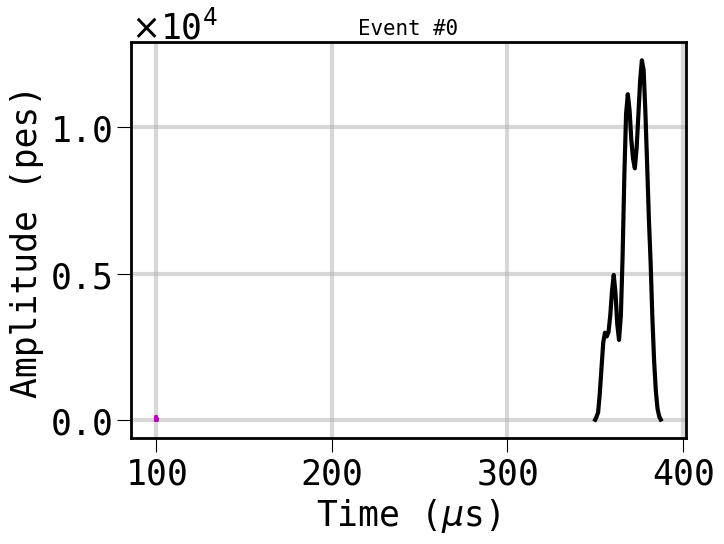

In [13]:
event_number, pmap = find_pmap_with_s1_s2(pmaps)

s1s, s2s, s2sis, s1pmts, s2pmts = pmaps_df
s1s   = s1s  .loc[lambda df: df.event == event_number]
s2s   = s2s  .loc[lambda df: df.event == event_number]
s2sis = s2sis.loc[lambda df: df.event == event_number]

for _, s1 in s1s.groupby("peak"):
    plt.plot(s1.time / 1e3, s1.ene, "m") # plot the PMT-summed waveform slice

for _, s2 in s2s.groupby("peak"):
    plt.plot(s2.time / 1e3, s2.ene, "k") # plot the PMT-summed waveform slice

plt.xlabel("Time ($\mu$s)")
plt.ylabel("Amplitude (pes)")
plt.title(f"Event #{event_number}", fontsize=15);

In [14]:
s1 = s1s  .loc[lambda df: df.peak == 0]
s2 = s2s  .loc[lambda df: df.peak == 0]
si = s2sis.loc[lambda df: df.peak == 0]

# need to add one bin for the total width!
dt = s2.time.max() - s2.time.min() + s2.bwidth.iloc[-1]

print(f"The PMT integral of the S2 is {s2.ene.sum():.1f} pes")
print(f"The SiPM integral of the S2 is {si.ene.sum():.1f} pes")
print(f"The width of the S2 is {dt/1e3:.1f} us")
print(f"The height of the S2 is {s2.ene.max():.1f} pes")
print(f"The S1 of this event happened at {s1.time.loc[s1.ene.idxmax()]/1e3:.2f} us")

The PMT integral of the S2 is 208740.8 pes
The SiPM integral of the S2 is 9913.1 pes
The width of the S2 is 37.8 us
The height of the S2 is 12289.2 pes
The S1 of this event happened at 100.10 us


# Notes